In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import VGG19_Weights

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

from collections import OrderedDict
from tqdm import tqdm  # For progress bar
import tarfile

from PIL import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
RANDOM_SEED = 42

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define dataset directory
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
data_dir = "./flowers_dataset"

In [5]:
# Create directory if not exists
os.makedirs(data_dir, exist_ok=True)

# Function to download dataset
def download_dataset(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url} ...")
        torch.hub.download_url_to_file(url, save_path)
        print(f"Saved to {save_path}")
    else:
        print(f"File already exists: {save_path}")

# Function to extract the dataset
def extract_dataset(dataset_path, file_path, extract_path):
    if not os.path.exists(dataset_path):
        print(f"Extracting {file_path}...")
        with tarfile.open(file_path, 'r:gz') as tar:
             tar.extractall(path=extract_path)
        print(f"Extracted to {extract_path}")
    else:
        print(f"Dataset already extracted to {extract_path}")

# Download dataset and labels
download_dataset(dataset_url, os.path.join(data_dir, "102flowers.tgz"))
download_dataset(labels_url, os.path.join(data_dir, "imagelabels.mat"))
# Extract the dataset
dataset_path = '/kaggle/working/flowers_dataset/jpg'
dataset_tgz = '/kaggle/working/flowers_dataset/102flowers.tgz'
extract_dataset(dataset_path, dataset_tgz, data_dir)

print("Dataset setup complete.")

100%|██████████| 329M/329M [00:13<00:00, 25.0MB/s] 


Saved to ./flowers_dataset/102flowers.tgz


100%|██████████| 502/502 [00:00<00:00, 896kB/s]


Saved to ./flowers_dataset/imagelabels.mat
Extracting /kaggle/working/flowers_dataset/102flowers.tgz...
Extracted to ./flowers_dataset
Dataset setup complete.


In [6]:
# Set dataset directory
data_dir = "./flowers_dataset"
images_dir = dataset_path
labels_path = os.path.join(data_dir, "imagelabels.mat")

# Load labels
labels = scipy.io.loadmat(labels_path)["labels"][0]  # Convert to array
labels -= 1  # Convert labels to zero-based indexing (0-101 instead of 1-102)

In [7]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNN models
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(15),  # Augmentation
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [8]:
# Custom Dataset Class
class FlowerDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.image_files = sorted(os.listdir(img_dir))  # Ensure order matches labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Load full dataset
dataset = FlowerDataset(images_dir, labels, transform=train_transform)

# Split dataset into train (50%), validation (25%), and test (25%)
total_size = len(dataset)
train_size = int(0.5 * total_size)
val_size = int(0.25 * total_size)
test_size = total_size - train_size - val_size  # Ensure full coverage

# Random split with different seed for reproducibility
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                         generator=torch.Generator().manual_seed(RANDOM_SEED))

In [10]:
# Apply different transforms for test & validation sets
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

In [11]:
# Load pretrained VGG19 model
vgg19 = models.vgg19(weights=VGG19_Weights.DEFAULT)
# Print the original model
print(vgg19)

# Freeze all convolutional layers (feature extractor)
for param in vgg19.features.parameters():
    param.requires_grad = False

# Modify classifier to output 102 classes instead of 1000
vgg19.classifier[-1] = nn.Linear(4096, 102)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = vgg19.to(device)
# Print the modified model
print(vgg19.classifier)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 87.1MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
# Create DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Check dataset sizes
print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)  # Optimize only FC layers

# Training parameters
num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")

    # Training phase
    vgg19.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Reset gradients
        outputs = vgg19(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Track loss & accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    vgg19.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = vgg19(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4%}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4%}")

    # Early stopping check
    if np.round(avg_val_loss,4) <= best_val_loss:
        best_val_loss = np.round(avg_val_loss,4)
        best_model_state = vgg19.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        num_epochs = epoch +1
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break

print("Training complete!")
torch.save(best_model_state, "vgg19_flower_classifier.pth")
print("Model saved successfully!")

Dataset sizes: Train=4094, Val=2047, Test=2048
Epoch 1/30:


100%|██████████| 128/128 [00:30<00:00,  4.24it/s]


Train Loss: 3.6873, Train Accuracy: 19.8828%
Val Loss: 2.0546, Val Accuracy: 50.5129%
Epoch 2/30:


100%|██████████| 128/128 [00:27<00:00,  4.73it/s]


Train Loss: 2.1568, Train Accuracy: 48.1925%
Val Loss: 1.5317, Val Accuracy: 58.1827%
Epoch 3/30:


100%|██████████| 128/128 [00:27<00:00,  4.62it/s]


Train Loss: 1.5516, Train Accuracy: 63.8495%
Val Loss: 1.3237, Val Accuracy: 66.0479%
Epoch 4/30:


100%|██████████| 128/128 [00:28<00:00,  4.54it/s]


Train Loss: 1.3475, Train Accuracy: 70.2491%
Val Loss: 1.3587, Val Accuracy: 69.7606%
Epoch 5/30:


100%|██████████| 128/128 [00:28<00:00,  4.43it/s]


Train Loss: 1.3470, Train Accuracy: 73.9375%
Val Loss: 1.4184, Val Accuracy: 68.4905%
Epoch 6/30:


100%|██████████| 128/128 [00:29<00:00,  4.40it/s]


Train Loss: 1.4978, Train Accuracy: 75.3298%
Val Loss: 1.4254, Val Accuracy: 69.1255%
Epoch 7/30:


100%|██████████| 128/128 [00:29<00:00,  4.30it/s]


Train Loss: 1.2376, Train Accuracy: 80.5813%
Val Loss: 1.5781, Val Accuracy: 70.2003%
Epoch 8/30:


100%|██████████| 128/128 [00:29<00:00,  4.29it/s]


Train Loss: 1.4175, Train Accuracy: 80.5081%
Val Loss: 1.6274, Val Accuracy: 71.2262%
Early stopping triggered at epoch 8
Training complete!
Model saved successfully!


In [13]:
# Load the trained model
vgg19.load_state_dict(torch.load("vgg19_flower_classifier.pth", map_location=device, weights_only=True))
print("Model loaded successfully!")
# Set model to evaluation mode
vgg19.eval()

# Track test loss & accuracy
test_loss, correct_test, total_test = 0.0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():  # No gradients needed for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg19(images)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Store predictions & labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final test accuracy
test_accuracy = correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4%}")

Model loaded successfully!
Test Loss: 1.5693, Test Accuracy: 70.8008%


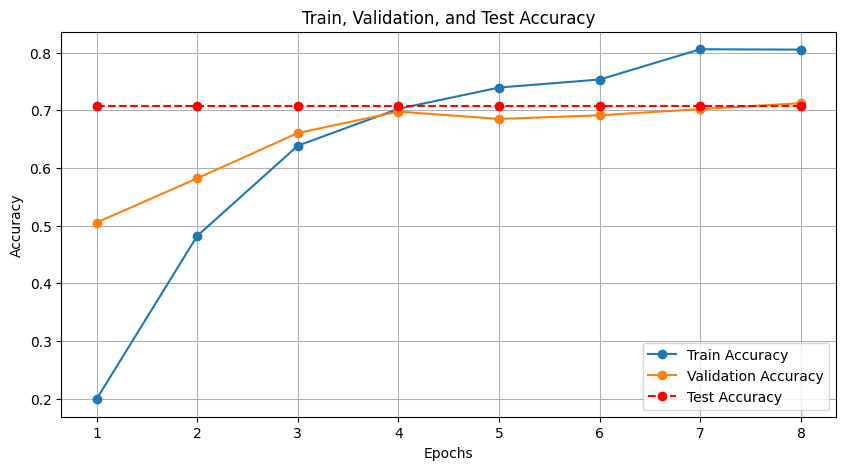

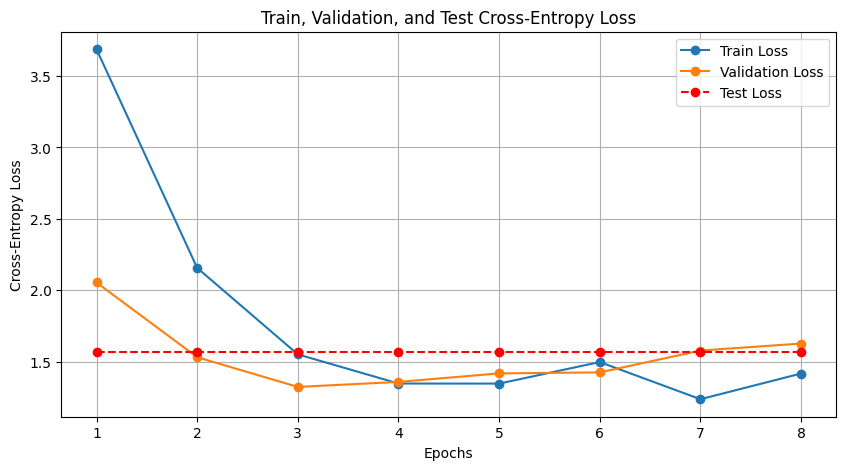

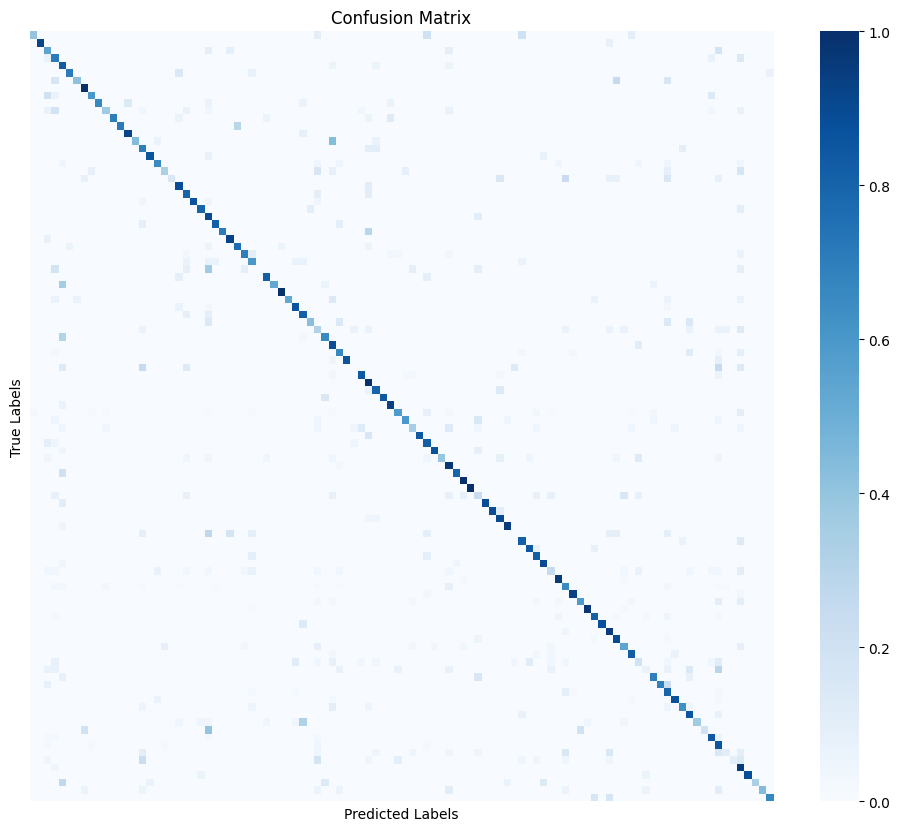

In [14]:
test_losses = [avg_test_loss] * num_epochs  # Since test set is evaluated once
test_accuracies = [test_accuracy] * num_epochs  # Same reason as above

# Plot Accuracy Curves (Train, Val, Test)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies, label="Test Accuracy", linestyle='dashed', marker='o', color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train, Validation, and Test Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot Cross-Entropy Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", linestyle='dashed', marker='o', color="red")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Train, Validation, and Test Cross-Entropy Loss")
plt.legend()
plt.grid()
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix to be in the range [0, 1]
conf_matrix = conf_matrix.astype("float") / conf_matrix.sum(axis=1, keepdims=True)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, cmap="Blues", annot=False, xticklabels=False, yticklabels=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()